In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import datetime as dt
import pickle
import os
import sys

sys.path.insert(0, '../../src')
import Models as models
import ModelUtils as mutils
import DataUtils as dutils
from scipy.io import loadmat
from sklearn.feature_selection import mutual_info_regression

from time import time

start_path = "/content/drive"

plt.rcParams.update({ "text.usetex": True, "font.family": "serif" })
font = {'size': 44}
matplotlib.rc('font', **font)
fmt = 'pdf'

In [2]:
def plot_3D(data, title, ax_var):
    fig = plt.figure(figsize=(10, 7))
    skip = 100
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    for ii in np.arange(0, data.shape[0], skip):
        ax.plot3D(data[ii, :, 0], data[ii, :, 1], data[ii, :, 2], '-', linewidth=1)
    #ax.scatter(data[::skip, 0, 0], data[::skip, 0, 1], data[::skip, 0, 2])
    ax.grid()
    ax.set_xlabel(r"$" + ax_var + "_{1}$", labelpad=20)
    ax.set_ylabel(r"$" + ax_var + "_{2}$", labelpad=20)
    ax.set_zlabel(r"$" + ax_var + "_{3}$", labelpad=20)
    ax.set_title(title)
    plt.savefig(title + "." + fmt, dpi=150,bbox_inches='tight',format=fmt)

In [3]:
# Load the model hyperparameters
chkpt_folder = 'Rossler_tune_2023-06-01-0013'
data_fname = f"data_Rossler_tune.pkl"
data = pickle.load(open(data_fname,'rb'))
    
DEVICE, DTYPE, CDTYPE = mutils.device_setup(0, 'single')
hyp_fname = ''.join(['./checkpoints/', chkpt_folder, '/model_hyperparams.pkl'])
perm_fname = ''.join(['./checkpoints/', chkpt_folder, '/permvec.pkl'])
train_history_fname = ''.join(['./checkpoints/', chkpt_folder, '/train_history.pkl'])
val_history_fname = ''.join(['./checkpoints/', chkpt_folder, '/val_history.pkl'])
hyp = pickle.load(open(hyp_fname, 'rb'))
perm = pickle.load(open(perm_fname , 'rb'))
train_history = pickle.load(open(train_history_fname , 'rb'))
val_history = pickle.load(open(val_history_fname , 'rb'))
# Set RNG seeds
mutils.seed_model(hyp)
# Shuffle data
shuffled_data = data[perm, ...]

Device available: cpu
Using device: cpu
Using precision (real/complex): torch.float32/torch.complex64


In [4]:
ii_train = hyp['num_train']
ii_test = ii_train + hyp['num_test']
ii_val = ii_test + hyp['num_val']
    
#train_dataset = torch.tensor(shuffled_data[:ii_train, ...], dtype=hyp['dtype'],
#                          device=torch.device(hyp['device']))
    
#test_dataset = torch.tensor(shuffled_data[ii_train:ii_test, ...], dtype=hyp['dtype'],
#                          device=torch.device(hyp['device']))    
    
#train_dataloader = DataLoader(train_dataset, batch_size=hyp['batch_size'],
#                              shuffle=True, drop_last=True)
    
train_dataset = torch.tensor(shuffled_data[:ii_train, ...], dtype=hyp['dtype'], 
                             device=torch.device('cpu'))
    
test_datan = shuffled_data[ii_train:ii_test, ...]
    
test_dataset = torch.tensor(shuffled_data[ii_train:ii_test, ...], dtype=hyp['dtype'],
                              device=torch.device('cpu'))    
    
train_dataloader = DataLoader(train_dataset, batch_size=hyp['batch_size'], 
                              shuffle=True, drop_last=True)

test_dataloader = DataLoader(test_dataset, batch_size=hyp['batch_size'], 
                              shuffle=True, drop_last=True)

In [5]:
# Load the trained model
model_fname = ''.join(['./checkpoints/', chkpt_folder, '/trained_model'])
model = models.Hankel_DLDMD(hyp)
model.load_state_dict(torch.load(model_fname, map_location=torch.device('cpu')))
model.eval()
model.device = 'cpu'
model.to(torch.device('cpu'))
loss_fn = models.Hankel_DLDMD_Loss(hyp)

In [6]:
# Load and run the trained model
bsize = hyp['batch_size']
nfull_batches = int(np.floor(test_dataset.shape[0]/bsize))
print(nfull_batches)
print(test_dataset.shape[0])
window = hyp['num_pred'] - hyp['num_observables'] + 1

7
2000


In [7]:
latent_data = np.zeros((bsize*nfull_batches, test_datan.shape[1], test_datan.shape[2]), dtype=np.float32)
advanced_data = np.zeros((bsize*nfull_batches, window-1, test_datan.shape[2]), dtype=np.float32)
for cnt in range(nfull_batches):
    results = model(test_dataset[cnt*bsize:(cnt+1)*bsize, :, :])
    y, x_ae, x_adv, y_adv = dutils.host_detach_np(results)
    latent_data[cnt*bsize:(cnt+1)*bsize,:,:] = y
    advanced_data[cnt*bsize:(cnt+1)*bsize,:,:] = x_adv
    

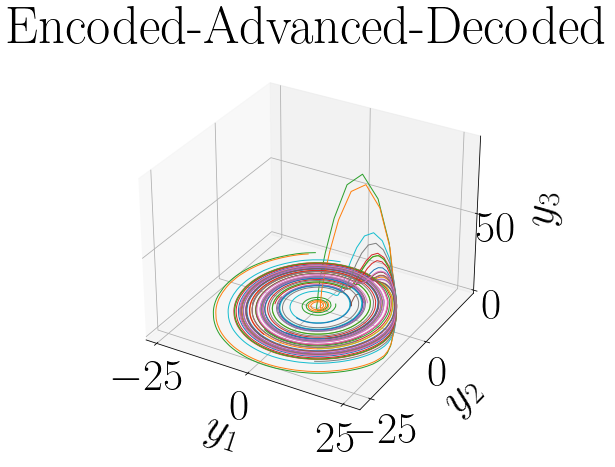

In [8]:
plot_3D(advanced_data[:, :, :], 'Encoded-Advanced-Decoded', 'y')

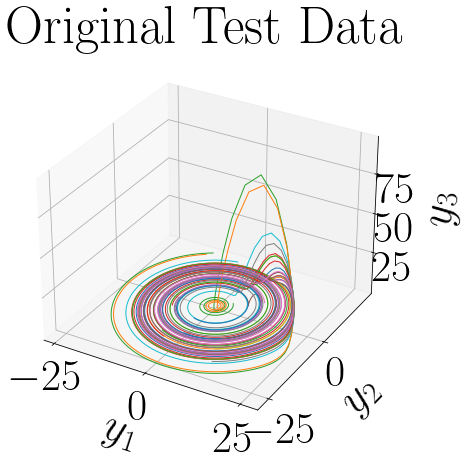

In [9]:
plot_3D(test_datan[:nfull_batches*bsize, hyp['ysteps']:, :], 'Original Test Data', 'y')

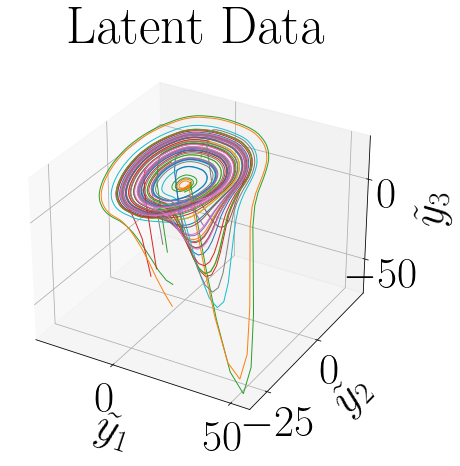

In [10]:
plot_3D(latent_data, 'Latent Data', "\\tilde{y}")

In [11]:
nlags = 40
skp = hyp['ysteps']

lags = np.arange(1, nlags+1)
mioriginal = np.zeros((bsize*nfull_batches,nlags,3))
milatent = np.zeros((bsize*nfull_batches,nlags,3))
mioriginalcterms = np.zeros((bsize*nfull_batches,nlags,3))
milatentcterms = np.zeros((bsize*nfull_batches,nlags,3))

start = time()

for ll in range(bsize*nfull_batches):
    for kk in range(nlags):
        for mm in range(3):
            mioriginal[ll,kk,mm] = mutual_info_regression(test_datan[ll, skp:, mm].reshape(-1, 1), np.roll(test_datan[ll, skp:, mm], lags[kk]))
            milatent[ll,kk,mm] = mutual_info_regression(latent_data[ll, skp:, mm].reshape(-1, 1), np.roll(latent_data[ll, skp:, mm], lags[kk]))
        
        mioriginalcterms[ll,kk,0] = mutual_info_regression(test_datan[ll, skp:, 0].reshape(-1, 1), np.roll(test_datan[ll, skp:, 1], lags[kk]))
        milatentcterms[ll,kk,0] = mutual_info_regression(latent_data[ll, skp:, 0].reshape(-1, 1), np.roll(latent_data[ll, skp:, 1], lags[kk]))
        
        mioriginalcterms[ll,kk,1] = mutual_info_regression(test_datan[ll, skp:, 0].reshape(-1, 1), np.roll(test_datan[ll, skp:, 2], lags[kk]))
        milatentcterms[ll,kk,1] = mutual_info_regression(latent_data[ll, skp:, 0].reshape(-1, 1), np.roll(latent_data[ll, skp:, 2], lags[kk]))
        
        mioriginalcterms[ll,kk,2] = mutual_info_regression(test_datan[ll, skp:, 1].reshape(-1, 1), np.roll(test_datan[ll, skp:, 2], lags[kk]))
        milatentcterms[ll,kk,2] = mutual_info_regression(latent_data[ll, skp:, 1].reshape(-1, 1), np.roll(latent_data[ll, skp:, 2], lags[kk]))
        
end = time()

print(f"{end-start}")
        
pickle.dump(mioriginal, open('mioriginal.pkl','wb'))    
pickle.dump(milatent, open('milatent.pkl','wb'))    
pickle.dump(mioriginalcterms, open('mioriginalcterms.pkl','wb'))    
pickle.dump(milatentcterms, open('milatentcterms.pkl','wb'))    

3389.331079006195


In [12]:
meanorigx = np.mean(mioriginal[:,:,0],0)
meanlatentx = np.mean(milatent[:,:,0],0)
varorigx = np.sqrt( np.mean( ( mioriginal[:,:,0] - np.tile(meanorigx, (bsize*nfull_batches, 1))  )**2., 0))
varlatentx = np.sqrt( np.mean( ( milatent[:,:,0] - np.tile(meanlatentx, (bsize*nfull_batches, 1))  )**2., 0))

meanorigy = np.mean(mioriginal[:,:,1],0)
meanlatenty = np.mean(milatent[:,:,1],0)
varorigy = np.sqrt( np.mean( ( mioriginal[:,:,1] - np.tile(meanorigy, (bsize*nfull_batches, 1))  )**2., 0))
varlatenty = np.sqrt( np.mean( ( milatent[:,:,1] - np.tile(meanlatenty, (bsize*nfull_batches, 1))  )**2., 0))

meanorigz = np.mean(mioriginal[:,:,2],0)
meanlatentz = np.mean(milatent[:,:,2],0)
varorigz = np.sqrt( np.mean( ( mioriginal[:,:,2] - np.tile(meanorigz, (bsize*nfull_batches, 1))  )**2., 0))
varlatentz = np.sqrt( np.mean( ( milatent[:,:,2] - np.tile(meanlatentz, (bsize*nfull_batches, 1))  )**2., 0))

meanorigxy = np.mean(mioriginalcterms[:,:,0],0)
meanlatentxy = np.mean(milatentcterms[:,:,0],0)

meanorigxz = np.mean(mioriginalcterms[:,:,1],0)
meanlatentxz = np.mean(milatentcterms[:,:,1],0)

meanorigyz = np.mean(mioriginalcterms[:,:,2],0)
meanlatentyz = np.mean(milatentcterms[:,:,2],0)

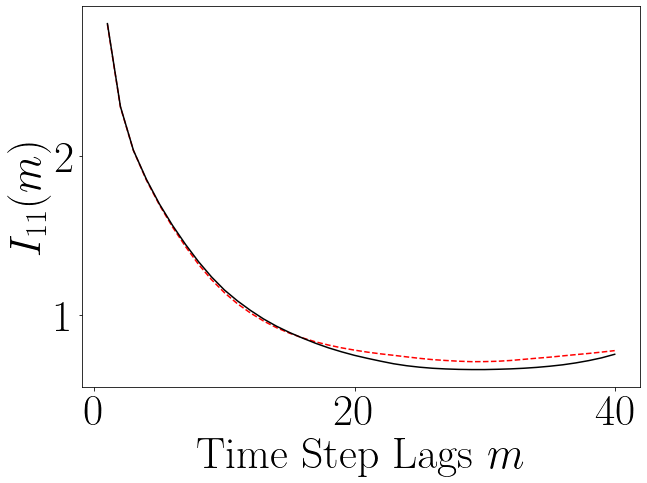

In [13]:
plt.plot(lags, meanorigx, color='r', ls='--', label='original')
plt.plot(lags, meanlatentx, color='k', label='latent')
plt.xlabel(r"Time Step Lags $m$")
plt.ylabel(r"$I_{11}(m)$")
#plt.legend()
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 7)
plt.savefig("MI_x_axis."+fmt, dpi=150,bbox_inches='tight',format=fmt)

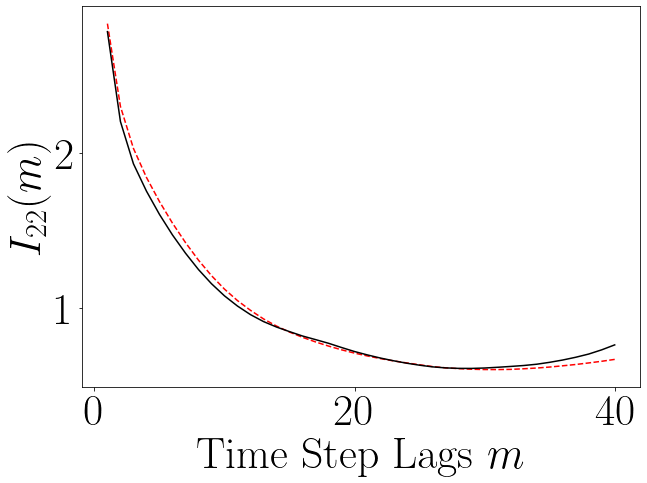

In [14]:
plt.plot(lags, meanorigy, color='r', ls='--', label='original')
plt.plot(lags, meanlatenty, color='k', label='latent')
plt.xlabel(r"Time Step Lags $m$")
plt.ylabel(r"$I_{22}(m)$")
#plt.legend()
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 7)
plt.savefig("MI_y_axis."+fmt, dpi=150,bbox_inches='tight',format=fmt)

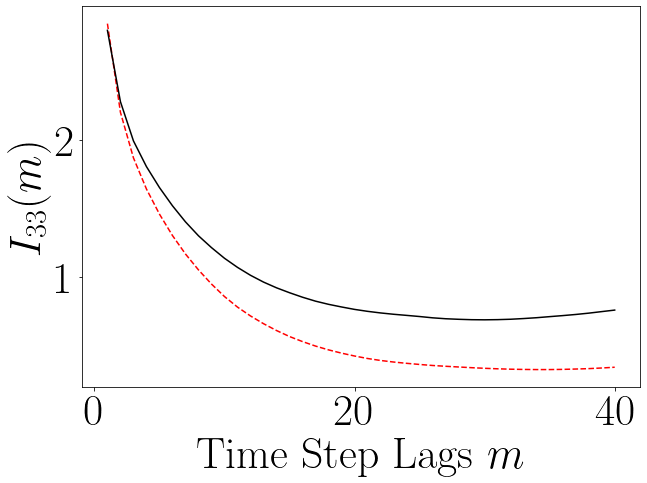

In [15]:
plt.plot(lags, meanorigz, color='r', ls='--', label='original')
plt.plot(lags, meanlatentz, color='k', label='latent')
plt.xlabel(r"Time Step Lags $m$")
plt.ylabel(r"$I_{33}(m)$")
#plt.legend()
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 7)
plt.savefig("MI_z_axis."+fmt, dpi=150,bbox_inches='tight',format=fmt)

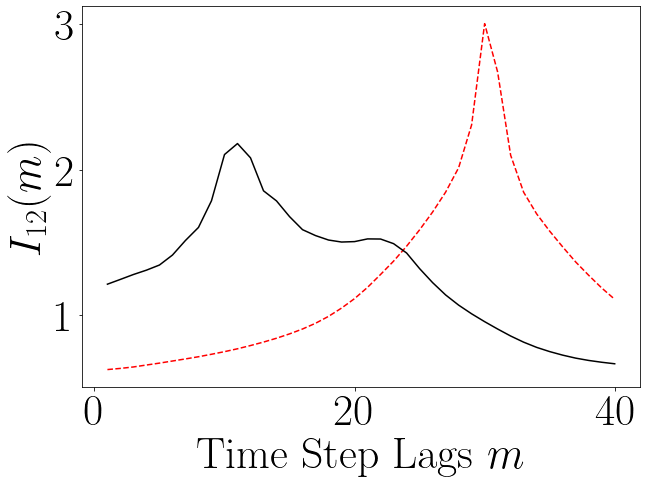

In [16]:
plt.plot(lags, meanorigxy, color='r', ls='--', label='original')
plt.plot(lags, meanlatentxy, color='k', label='latent')
plt.xlabel(r"Time Step Lags $m$")
plt.ylabel(r"$I_{12}(m)$")
#plt.legend()
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 7)
plt.savefig("MI_xy_axes."+fmt, dpi=150,bbox_inches='tight',format=fmt)

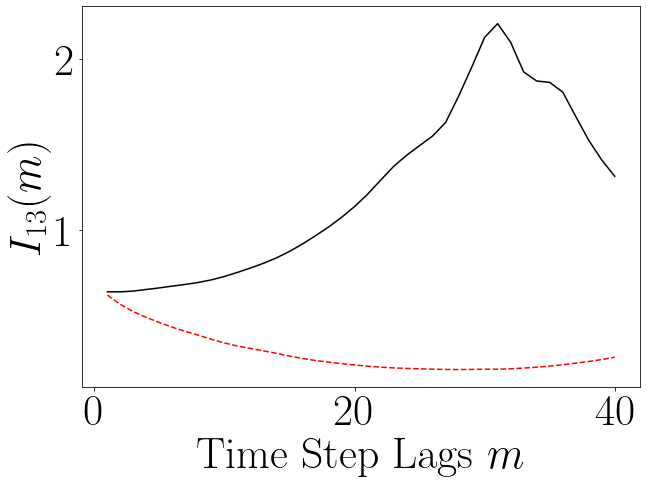

In [17]:
plt.plot(lags, meanorigxz, color='r', ls='--', label='original')
plt.plot(lags, meanlatentxz, color='k', label='latent')
plt.xlabel(r"Time Step Lags $m$")
plt.ylabel(r"$I_{13}(m)$")
#plt.legend()
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 7)
plt.savefig("MI_xz_axes."+fmt, dpi=150,bbox_inches='tight',format=fmt)

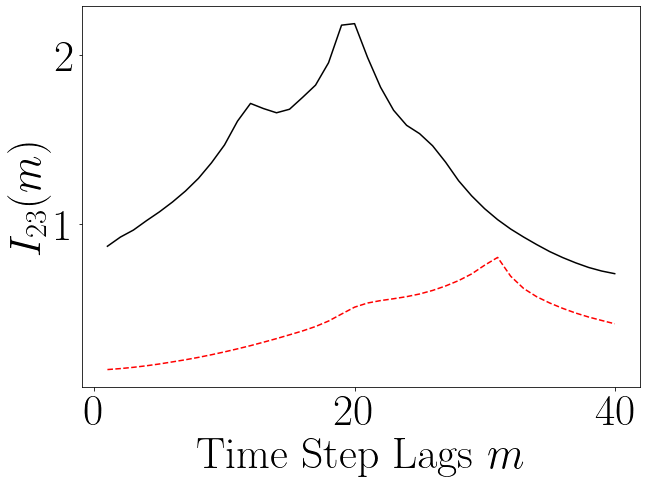

In [18]:
plt.plot(lags, meanorigyz, color='r', ls='--', label='original')
plt.plot(lags, meanlatentyz, color='k', label='latent')
plt.xlabel(r"Time Step Lags $m$")
plt.ylabel(r"$I_{23}(m)$")
#plt.legend()
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 7)
plt.savefig("MI_yz_axes."+fmt, dpi=150,bbox_inches='tight',format=fmt)

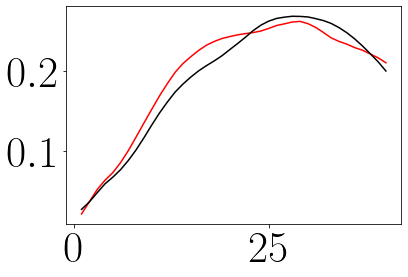

In [19]:
plt.plot(lags, varorigx/meanorigx, color='r')
plt.plot(lags, varlatentx/meanlatentx, color='k')

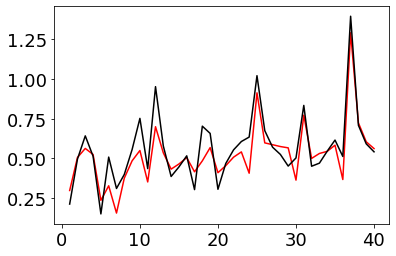

In [12]:
plt.plot(lags, varorigy/meanorigy, color='r')
plt.plot(lags, varlatenty/meanlatenty, color='k')

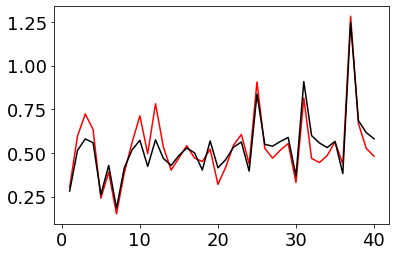

In [13]:
plt.plot(lags, varorigz/meanorigz, color='r')
plt.plot(lags, varlatentz/meanlatentz, color='k')

(array([536., 613., 155.,  70.,  90.,  54.,  44.,  43.,  51., 136.]),
 array([0.47794987, 0.66945668, 0.8609635 , 1.05247032, 1.24397714,
        1.43548396, 1.62699077, 1.81849759, 2.01000441, 2.20151123,
        2.39301805]),
 <BarContainer object of 10 artists>)

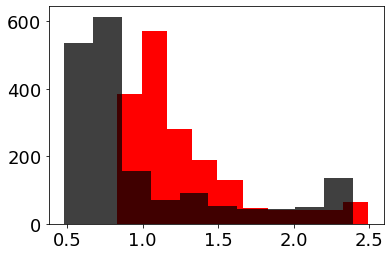

In [14]:
lval = 5
plt.hist(mioriginal[:,lval,0],color='r')
plt.hist(milatent[:,lval,0],color='k',alpha=.75)

In [15]:
uval = int(np.floor(np.random.uniform(0, bsize*nfull_batches)))
print(uval)

frqorigx = np.abs(np.fft.fft(test_datan[uval, skp:, 0]))
frqlatx = np.abs(np.fft.fft(latent_datan[uval, skp:, 0]))

frqorigy = np.abs(np.fft.fft(test_datan[uval, skp:, 1]))
frqlaty = np.abs(np.fft.fft(latent_datan[uval, skp:, 1]))

frqorigz = np.abs(np.fft.fft(test_datan[uval, skp:, 2]))
frqlatz = np.abs(np.fft.fft(latent_datan[uval, skp:, 2]))

ntstps = test_datan.shape[1]
frqaxis = np.arange(int(ntstps/2))/(2.*np.pi)

1003


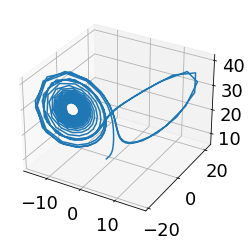

In [16]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(test_datan[uval, skp:, 0], test_datan[uval, skp:, 1], test_datan[uval, skp:, 2])

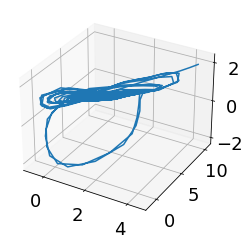

In [17]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(latent_datan[uval, skp:, 0], latent_datan[uval, skp:, 1], latent_datan[uval, skp:, 2])

In [18]:
origpowerx = np.sqrt(np.sum(np.abs(frqorigx)**2.))
latpowerx = np.sqrt(np.sum(np.abs(frqlatx)**2.))

origpowery = np.sqrt(np.sum(np.abs(frqorigy)**2.))
latpowery = np.sqrt(np.sum(np.abs(frqlaty)**2.))

origpowerz = np.sqrt(np.sum(np.abs(frqorigz)**2.))
latpowerz = np.sqrt(np.sum(np.abs(frqlatz)**2.))

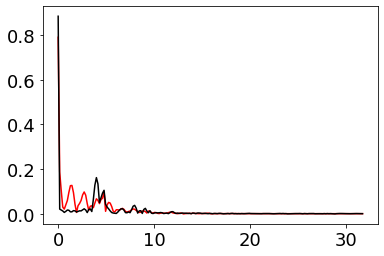

In [19]:
plt.plot(frqaxis, frqorigx[:int(ntstps/2)]/origpowerx,color='r')
plt.plot(frqaxis,frqlatx[:int(ntstps/2)]/latpowerx,color='k')

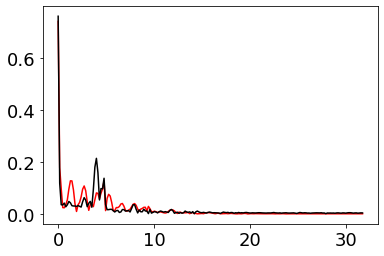

In [20]:
plt.plot(frqaxis, frqorigy[:int(ntstps/2)]/origpowery,color='r')
plt.plot(frqaxis,frqlaty[:int(ntstps/2)]/latpowery,color='k')

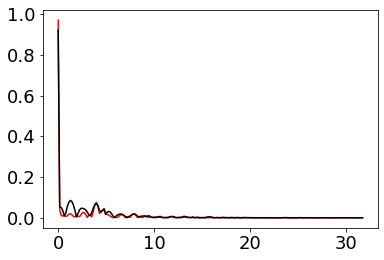

In [21]:
plt.plot(frqaxis, frqorigz[:int(ntstps/2)]/origpowerz,color='r')
plt.plot(frqaxis,frqlatz[:int(ntstps/2)]/latpowerz,color='k')

In [34]:
print(-np.log2(10))
print(.1*2^)

-3.321928094887362
